<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/train_pass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
%cd /content/drive/MyDrive/Colab/password/

/content/drive/MyDrive/Colab/password


In [101]:
import os
import time

import tensorflow as tf

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


In [102]:
data = open('data/passwords_db.txt',).read()

In [103]:
len(data)

178313552

In [104]:
passwds = data.split("\n")

In [105]:
len(passwds)

18308617

# Vectorize the text

In [106]:
vocab = sorted(list(set(''.join(passwds))))

In [107]:
len(vocab)

95

In [108]:
char_indices = dict((c, i) for i, c in enumerate(vocab))
indices_char = dict((i, c) for i, c in enumerate(vocab))

In [109]:
max_len = max(passwds, key=len)

In [110]:
len(max_len)

50

In [111]:
print(f"Total number of passwords {len(passwds)}")
print(f"Passwords vocab size {len(vocab)}")
print(f"Max passwords length {len(max_len)}")

Total number of passwords 18308617
Passwords vocab size 95
Max passwords length 50


In [112]:
input_text = [p[:-1] for p in passwds]
target_text = [p[1:] for p in passwds]

In [113]:
print(f"{passwds[0]} {input_text[0]} {target_text[0]}")

12STEVEN 12STEVE 2STEVEN


In [114]:
# Creating like below will blow memory

# input_data = np.zeros( (len(passwds), len(max_len), len(vocab)) ,dtype='float32')
# target_data = np.zeros( (len(passwds), len(max_len), len(vocab)) ,dtype='float32')

# nearly took 17 GB of RAM memory for 1 million records
# dataset has 14 million records
# one_m_records = np.zeros( (1000000, 50, 95) ,dtype='float32')

# clean memory
# del one_m_records


In [115]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True, lower=False)
tokenizer.fit_on_texts(passwds)

In [116]:
input_tensor = tokenizer.texts_to_sequences(input_text)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, padding='post')

In [117]:
input_tensor.shape

(18308617, 49)

In [118]:
target_tensor = tokenizer.texts_to_sequences(target_text)
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post')

In [119]:
target_tensor.shape

(18308617, 49)

In [120]:
[''.join(i.split()) for i in tokenizer.sequences_to_texts(input_tensor[:5])]

['12STEVE', 'pedroantunescaetan', 'nanloveken', 'cyvoe', '2011kai']

In [121]:
[''.join(i.split()) for i in tokenizer.sequences_to_texts(target_tensor[:5])]

['2STEVEN', 'edroantunescaetano', 'anlovekeng', 'yvoet', '011kaid']

In [122]:
len(tokenizer.word_index)

95

# Split data into Train and Validation

In [123]:
# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
BUFFER_SIZE = 10000

# split to 70 30 
input_tensor_train, input_tensor_rem, target_tensor_train, target_tensor_rem = train_test_split(input_tensor, target_tensor, test_size=0.3, shuffle=True)

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# split to 50 50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_rem, target_tensor_rem, test_size=0.5)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [124]:
# For performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [125]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 49]), TensorShape([32, 49]))

In [126]:
vocab_size = len(tokenizer.word_index) + 1

max_length_input = input_tensor.shape[1]
max_length_output = target_tensor.shape[1]

embedding_dim = vocab_size
rnn_units = 2048

print(f'Vocab size {vocab_size}')
print(f"Max input length {max_length_input}")
print(f"Max input length {max_length_output}")

Vocab size 96
Max input length 49
Max input length 49


In [127]:
input_tensor_train.shape

(12816031, 49)

# Create Model

In [128]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, states_h, states_c = self.lstm(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states_h, states_c
    else:
      return x

In [129]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [130]:
# try model without training
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(32, 49, 96) # (batch_size, sequence_length, vocab_size)


In [131]:
model.summary()

Model: "my_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    multiple                  9216      
                                                                 
 lstm_3 (LSTM)               multiple                  17571840  
                                                                 
 dense_9 (Dense)             multiple                  196704    
                                                                 
Total params: 17,777,760
Trainable params: 17,777,760
Non-trainable params: 0
_________________________________________________________________


In [132]:
input_example_batch

<tf.Tensor: shape=(32, 49), dtype=int32, numpy=
array([[ 9,  1, 21, ...,  0,  0,  0],
       [30,  1, 11, ...,  0,  0,  0],
       [21,  7, 28, ...,  0,  0,  0],
       ...,
       [58, 39, 51, ...,  0,  0,  0],
       [18, 12, 16, ...,  0,  0,  0],
       [38, 56, 36, ...,  0,  0,  0]], dtype=int32)>

In [133]:
tf.random.categorical(example_batch_predictions[0], num_samples=1)

<tf.Tensor: shape=(49, 1), dtype=int64, numpy=
array([[77],
       [15],
       [95],
       [90],
       [68],
       [64],
       [54],
       [18],
       [64],
       [49],
       [20],
       [13],
       [30],
       [56],
       [47],
       [ 3],
       [12],
       [ 8],
       [ 8],
       [29],
       [42],
       [94],
       [ 9],
       [94],
       [62],
       [75],
       [48],
       [69],
       [95],
       [16],
       [64],
       [47],
       [48],
       [ 8],
       [49],
       [55],
       [14],
       [ 7],
       [60],
       [ 6],
       [36],
       [60],
       [17],
       [89],
       [67],
       [ 1],
       [48],
       [60],
       [88]])>

In [134]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [135]:
[tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in example_batch_predictions] 

[array([69, 21, 52,  2, 64,  4,  5, 29,  6,  3, 93, 41, 56, 67, 22, 31,  4,
        94, 33,  2, 87, 59, 86, 32,  6, 22, 21,  2, 82, 41, 14, 82, 63, 14,
        18,  2, 69,  7, 92, 18,  5, 93,  6, 19, 36, 23, 38, 34, 88]),
 array([ 9, 66, 74, 48, 55, 71, 49, 21, 29, 95, 47, 74, 70, 14, 54, 34, 21,
        67, 84, 64, 33, 30, 60, 46, 43, 87, 57, 61, 13, 52, 54, 28, 42, 10,
        63, 40, 92, 14,  0, 56, 49,  0, 60, 70, 94, 55, 10, 21, 57]),
 array([74, 92, 43, 85,  3, 67, 86, 27, 11, 53, 86, 22, 17, 57, 78, 88, 61,
        55, 73, 65, 78, 22, 78, 14, 94, 93, 79, 77, 13, 81, 94, 64, 11, 15,
        34,  5, 26, 22, 39, 17, 51, 17, 74, 22, 53,  9, 71, 29, 36]),
 array([58, 18, 17, 29, 90, 53, 47,  9, 79,  3, 56, 81, 67, 15, 62, 30, 28,
        56, 17, 86, 26, 58, 69, 92, 83, 14, 40, 15, 27, 51, 15, 44, 19, 80,
        78, 43, 69, 60, 80, 78, 29,  9, 22, 53, 49, 33, 82, 57, 33]),
 array([83, 72,  0, 82, 36, 41, 44, 11, 85, 58, 29, 33, 84, 23, 49, 76, 78,
        64, 14, 55, 82, 89, 30, 10, 

In [136]:
tokenizer.sequences_to_texts([tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in example_batch_predictions] )

['2 h 6 A ) x o " # j N 9 0 9 " " 9 j J : { P @ * f c s 8 { k 9 - x H 1 " m w S # ; F 6 ? X S ` f',
 '] 0 n F 9 p * " @ u , I ,   J j b ( | ` F 3 q $ K J = Y O ) ~ 0   M F . > 5 0 0 B f U g t }   h y',
 "5 N B % 7 n u X 8 \\ t \\ k b ^ Y U Z H 6 3 G / L G w = . X ' Q C q m e Y w ? p Q p r O P Q ~ z",
 "B M # t 3 G ) Y 7 G [ $ x 2 r   } ' P R P > . x c 8 Y $ h + * g y S A a e ? M e 9 e e B _ - o",
 '5   N s 5 l U \\ V \\ M + 3 m T b S L 2 V 1 C B E 4 z 5 1 J ; 4 J ! R m H 2 h R i g G n m f K Y 6 Y',
 '( @ # R ) 6 J ( h R a R ( d   t & 1 , A ` p r 4 r c z % S f F v \\ f q c _ j v K W R K - F 1 ] 1 _',
 'G Y x v } q L < 1 U M a L I o ) f M ? L 5 7 / B g ^ V a R Z ; - _ 4 T < O P f   R c 3 7 E p e V',
 '1 L ^ ` d / ) { ) l a I e ` | [ l 8 ` Z o d b l = > P Q | _ w n v ^ = F N H B & < R W ; $ U B 5 0',
 'a , ; e   2 ~ U > " ] { k = x 6 V W R ? ?   C O 6 ? t * = , 6 R : l i j w e \' { K z p q T A [ % a',
 '9 0 | S M $ j ~ : = W 2 $ e L d Y G : x C | u - p - ( * r \\ Y ; K c V L o f s . i " =

In [137]:
sampled_indices

array([ 9, 86, 50, 82, 45, 34,  8, 24, 47, 43, 39, 46, 38, 27, 80, 49, 14,
       78, 58, 90, 32, 47,  8, 56, 81, 34, 94, 70, 76,  5, 85, 25, 80, 23,
       57, 83, 70,  3, 72, 42,  3, 90, 73, 18, 54, 13, 31, 63, 65])

In [138]:
input_example_batch[0].numpy()

array([ 9,  1, 21, 25, 13, 14,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [139]:
print(f"Input: {[''.join(i.split()) for i in tokenizer.sequences_to_texts([input_example_batch[0].numpy()]) ]}")
print(f"next char prediction : {[''.join(i.split()) for i in tokenizer.sequences_to_texts([sampled_indices]) ]}")

Input: ['racy382']
next char prediction : ["r~.%TznhDNOCIk(B8)J`vDnP'z}Q\\i<y(u_;Q1$L1`,6U3f*W"]


# Train Model

In [140]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [141]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (32, 49, 96)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.5725007, shape=(), dtype=float32)


In [142]:
tf.exp(example_batch_mean_loss).numpy()

96.785835

In [143]:
input_example_batch.numpy()

array([[ 9,  1, 21, ...,  0,  0,  0],
       [30,  1, 11, ...,  0,  0,  0],
       [21,  7, 28, ...,  0,  0,  0],
       ...,
       [58, 39, 51, ...,  0,  0,  0],
       [18, 12, 16, ...,  0,  0,  0],
       [38, 56, 36, ...,  0,  0,  0]], dtype=int32)

In [144]:
tokenizer.sequences_to_texts(input_example_batch.numpy())

['r a c y 3 8 2',
 'j a s o n z 2',
 'c o g l i o s t r o 2 1 1 8 0',
 'y e q r a h i',
 't g u n i t 8',
 'g r e g c',
 '8 2 1 9 3 c',
 's o p 1 m a c',
 'b o e s s',
 'j p n p x x k',
 '4 7 5 1 0 2 5',
 'g o b o t 2 0 0',
 '0 9 2 7 0 7 4 0 5',
 'K D E I N N',
 '0 8 5 8 2 6 3 5 8',
 '# 1 p i n k g i r',
 'S t d 0 0 1 8 1 2',
 '4 9 4 3 4 1 0 1',
 'l i s s e t h 2',
 '1 1 0 5 6 9 A',
 'l e k k',
 'm a k n a b a',
 'k y s e r',
 '1 9 6 9 h i j',
 '8 9 0 8 2 0 0 1 5 3 0',
 'K Y L A H 3 9 2',
 '8 1 7 6 1 2',
 'b b o o n n u u s',
 'c h v 1 2 3',
 'J O H A N N',
 '6 9 4 6 6 9',
 'I P E F I']

In [145]:
[p.split() for p in tokenizer.sequences_to_texts(input_example_batch.numpy())]

[['r', 'a', 'c', 'y', '3', '8', '2'],
 ['j', 'a', 's', 'o', 'n', 'z', '2'],
 ['c', 'o', 'g', 'l', 'i', 'o', 's', 't', 'r', 'o', '2', '1', '1', '8', '0'],
 ['y', 'e', 'q', 'r', 'a', 'h', 'i'],
 ['t', 'g', 'u', 'n', 'i', 't', '8'],
 ['g', 'r', 'e', 'g', 'c'],
 ['8', '2', '1', '9', '3', 'c'],
 ['s', 'o', 'p', '1', 'm', 'a', 'c'],
 ['b', 'o', 'e', 's', 's'],
 ['j', 'p', 'n', 'p', 'x', 'x', 'k'],
 ['4', '7', '5', '1', '0', '2', '5'],
 ['g', 'o', 'b', 'o', 't', '2', '0', '0'],
 ['0', '9', '2', '7', '0', '7', '4', '0', '5'],
 ['K', 'D', 'E', 'I', 'N', 'N'],
 ['0', '8', '5', '8', '2', '6', '3', '5', '8'],
 ['#', '1', 'p', 'i', 'n', 'k', 'g', 'i', 'r'],
 ['S', 't', 'd', '0', '0', '1', '8', '1', '2'],
 ['4', '9', '4', '3', '4', '1', '0', '1'],
 ['l', 'i', 's', 's', 'e', 't', 'h', '2'],
 ['1', '1', '0', '5', '6', '9', 'A'],
 ['l', 'e', 'k', 'k'],
 ['m', 'a', 'k', 'n', 'a', 'b', 'a'],
 ['k', 'y', 's', 'e', 'r'],
 ['1', '9', '6', '9', 'h', 'i', 'j'],
 ['8', '9', '0', '8', '2', '0', '0', '1', '5', '

In [146]:
def bleu_score(y_true, y_pred):
  true_seq = tokenizer.sequences_to_texts(y_true.numpy())
  reference = [p.split() if p.split() else [' '] for p in true_seq]
  preds = [tf.squeeze(tf.random.categorical(pred, num_samples=1), axis=-1).numpy() for pred in y_pred]
  hypothesis = [p.split() if p.split() else [' '] for p in tokenizer.sequences_to_texts(preds)]
  return corpus_bleu(reference, hypothesis)

In [147]:
bleu_score(input_example_batch, example_batch_predictions)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.47552642083612184

In [148]:
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.006)

In [149]:
# GPU
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# Configure Checkpoints

In [150]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_lstm'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

earlystopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    patience = 3,
    restore_best_weights = True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only=True,
    save_weights_only=True, 
    verbose = 1)

In [151]:
EPOCHS = 20

history = model.fit(train_dataset, 
                    validation_data=val_dataset,
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback, earlystopping_cb])

Epoch 1/20
400498/400500 [============================>.] - ETA: 0s - loss: 0.4009 - accuracy: 0.8860
Epoch 1: val_accuracy improved from -inf to 0.88523, saving model to ./training_checkpoints_lstm/ckpt_1
400500/400500 [==============================] - 9626s 24ms/step - loss: 0.4009 - accuracy: 0.8860 - val_loss: 0.3939 - val_accuracy: 0.8852
Epoch 2/20
400500/400500 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.8884
Epoch 2: val_accuracy improved from 0.88523 to 0.88582, saving model to ./training_checkpoints_lstm/ckpt_2
400500/400500 [==============================] - 9532s 24ms/step - loss: 0.3923 - accuracy: 0.8884 - val_loss: 0.3920 - val_accuracy: 0.8858
Epoch 3/20
400500/400500 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8892
Epoch 3: val_accuracy improved from 0.88582 to 0.88616, saving model to ./training_checkpoints_lstm/ckpt_3
400500/400500 [==============================] - 9550s 24ms/step - loss: 0.3895 - accuracy: 0.

In [152]:
model.save('saved_model/password')

INFO:tensorflow:Assets written to: saved_model/password/assets


INFO:tensorflow:Assets written to: saved_model/password/assets


# Plot

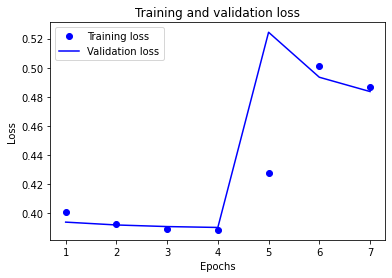

In [186]:
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

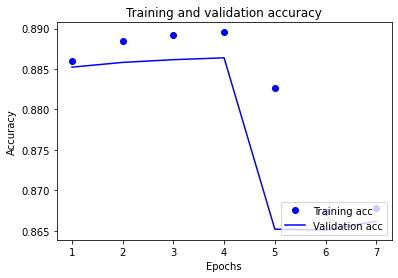

In [187]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# BLEU score on test dataset

In [155]:
# try model without training
scores = []
for input_test_batch, target_test_batch in test_dataset:
    test_batch_predictions = model(input_test_batch)
    scores.append(bleu_score(input_example_batch, test_batch_predictions))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [157]:
sum(scores)/len(scores)

0.6169241120548296

# Inference

In [172]:
class OneStep(tf.keras.Model):
  def __init__(self, model, tokenizer, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.tokenizer = tokenizer

  #@tf.function
  def generate_one_step(self, input_chars, states=None):
    #import pdb; pdb.set_trace()
    # Convert strings to token IDs.
    # input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.tokenizer.texts_to_sequences(input_chars)
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states_h, states_c = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.tokenizer.sequences_to_texts([predicted_ids.numpy()])

    # Return the characters and model state.
    return predicted_chars, [states_h, states_c]

In [173]:
one_step_model = OneStep(model, tokenizer)

In [174]:
start = time.time()
states = None
next_char = ['w']
result = [next_char]

for n in range(2):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

wed 

________________________________________________________________________________

Run time: 0.016946792602539062


In [175]:
def pwds_from_chars(start_char, len):
  states = None
  next_char = [start_char]
  result = [next_char]

  for n in range(len-1):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  result = tf.strings.join(result)
  return result[0].numpy().decode('utf-8')

In [185]:
all_pos = []
while True:
  pred = pwds_from_chars('p', 4)
  if pred not in all_pos:
    all_pos.append(pred)
  else:
    break

print(all_pos)

['paka', 'pplp', 'pook', 'pusa', 'p1x6', 'pari', 'prop', 'payt', 'palo', 'psr0', 'plea', 'peps', 'pedr', 'phat', 'pimy', 'puma', 'pe5a', 'pupp', 'play', 'pakd', 'prin', 'plut', 'pela', 'patr']


In [177]:
given_pass = 'Password1'
attempts = 1

while True:
  pred = pwds_from_chars(given_pass[0], len(given_pass))
  print(f"{attempts} - {pred}")
  if pred == given_pass:
    break
  attempts += 1

print(f"Model took {attempts} attempts to find password - {given_pass}")

1 - Perno1259
2 - Purice098
3 - Patience4
4 - PJABCrew3
5 - Portdolpi
6 - PraiseHop
7 - PictureWi
8 - P98041065
9 - PISCISTO0
10 - Passer469
11 - Proxlucks
12 - PopyNikes
13 - PANDA69CH
14 - Perry0606
15 - PeggyWigg
16 - Pnel08059
17 - PJ12jqks6
18 - Patsymon1
19 - PLAYBOY22
20 - PxZgtnzQ3
21 - PregleLan
22 - Pointon72
23 - PE4CESEXY
24 - POP214810
25 - PECOASTIO
26 - PROSPECTS
27 - PHONEspoo
28 - PXNDX8285
29 - PLK9999II
30 - PRINCE060
31 - P@nt15tv1
32 - Pfairview
33 - PALMEROAD
34 - PAO714518
35 - PATMC2815
36 - Pknhkl151
37 - PARLA9357
38 - P1d1aCK19
39 - Policia07
40 - PERFECT51
41 - PINKCHOPP
42 - Porkidoho
43 - Paulamarc
44 - P1m1n43v3
45 - PAUL08240
46 - Pineapple
47 - PAUL2004S
48 - PLUS12121
49 - PANERA123
50 - Pa1577971
51 - Pachola27
52 - Piochenta
53 - PREDESTIN
54 - Pussy2065
55 - Paje19802
56 - Potokal60
57 - PLAYBOIBO
58 - Penuta198
59 - PEDROFF10
60 - POUSSTIK5
61 - PRILLURE3
62 - POWEA69CH
63 - Pink424sH
64 - PbismisHe
65 - PASSMORE1
66 - PAINT3228
67 - PANGA3651
68 -

# Attempts calculation

In [180]:
def find_attempts(given_pwd):
  pass_len = len(given_pwd)
  attempts = 1
  # iterate through each starting letter. 
  for l in tokenizer.word_index.keys():
    states = None
    next_char = [l]
    result = [next_char]

    for n in range(pass_len-1):
      next_char, states = one_step_model.generate_one_step(next_char, states=states)
      result.append(next_char)
    
    result = tf.strings.join(result)
    pred = result[0].numpy().decode('utf-8')
    if pred == given_pwd:
      print(f"Model predicted password in {attempts}")
    else:
      attempts += 1

In [181]:
find_attempts('war')